# Analyzing Doctor Appointment No-Shows

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

We want to analyze a data set to see if we can discover patterns or indicators about whether or not someone is more likely to miss a doctor appointment.

Similar to how airline companies overbook their flights - assuming that some will not show-up - we may want to consider "overbooking" our doctor appointments assuming that some will not show up for their appointment. However, we do not want to be arbitrary in our scheduling.

We can leverage data from over 100,000 records of doctor appointments to uncover insights that can help us determine and predict whether or not they will show up for their appointment, based on a number of factors (health conditions, welfare status, location of doctor's office, and other relevant data points).

This project investigates such data and seeks to explore and reveal helpful insights that can help us make better, more efficient, and more profitable decisions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from datetime import datetime

<a id='wrangling'></a>
## Data Wrangling

Import the data intro a pandas dataframe and make some general observations.

### General Properties

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


### Data Cleaning

There are no null values, but there are two changes to make:<br>
1. Convert the No-Show appointment column to a more readable, intuitive name and value. I will change it from the negative to the positive by renaming the column to "ApptResult" with each cooresponding value as "Present" or "Missed."<br>
2. Change the Sholarship column to make the data make more sense<br>
3. To utilize the dates provided, I will parse out the month and the day for both the scheduled date and the appointment date.<br>
4. Remove same-day / walk-in appointments.<br>

Upon making these changes, I will export to a new, cleaned CSV file for future use.

#### Clean the No-show column

I want to first change the column name from No-show to ApptResult. This column name will be more intuitive to interpret.

In [133]:
df.rename(columns = {'No-show' : 'ApptResult'} , inplace=True)

Once we rename the column from No-show (which is in the negative), we need to rename the ApptResult column values from a "Yes" or "No" value to "Missed" or "Present", respectively.

In [134]:
df['ApptResult'].replace("No", 1, inplace=True)
df['ApptResult'].replace("Yes", 0, inplace=True)

#### Change Scholarship column to say WelfareScholarship

In [135]:
df.rename(columns = {'Scholarship' : 'WelfareScholarship'} , inplace=True)

#### Clean the date columns and add a new column that calculates the difference

Convert the AppointmentDate and ScheduledDate to datetime format

In [137]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format="%Y-%m-%d").dt.date
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format="%Y-%m-%d").dt.date

Add a column to the dataframe "DateDifference" to the dataframe

In [138]:
df['DateDifference'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

Retain rows where DateDifference is greater than 0. We can assume that these are walk-in appointments, and appointments scheduled after the appointment date must be a data-entry error.

In [139]:
df = df[df['DateDifference'] > 0]

#### Export the cleaned data to a new CSV

In [140]:
df.to_csv('cleaned-noshowappointments.csv', index=False)

In [141]:
df = pd.read_csv('cleaned-noshowappointments.csv')

In [142]:
df.query('ApptResult == 1').to_csv('appts-present.csv')
df.query('ApptResult == 0').to_csv('appts-missed.csv')

<a id='eda'></a>
## Exploratory Data Analysis

In [37]:
df = pd.read_csv('cleaned-noshowappointments.csv')
df_m = pd.read_csv('appts-missed.csv')
df_p = pd.read_csv('appts-present.csv')

In [38]:
df['ApptResult'].describe()
mean = df['ApptResult'].describe()[1]

##### Observations:
<li>71.4% of patients will show up for their appointment
<li>28.6% of patients will not show up for their appointment

#### 1. Does the amount of days between the schedule date and appointment date show a correlation to a missed appointment?

By looking at value_counts and analyzing the appointments histogram, we see that the data quickly tails off after 90 days. So we will examine two time periods: 0-30 days, the period with the most activity, and 0-90 days, covering a healthy spread.

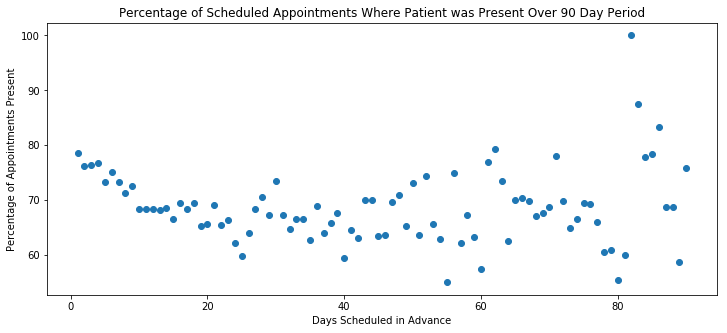

In [40]:
start = 0
end = 90
y = df.groupby('DateDifference')['ApptResult'].mean()[start:end]*100
x = range(start + 1, end + 1)
plt.figure(figsize=(12,5))
plt.scatter(x,y);
plt.title("Percentage of Scheduled Appointments Where Patient was Present Over 90 Day Period");
plt.xlabel("Days Scheduled in Advance");
plt.ylabel("Percentage of Appointments Present");

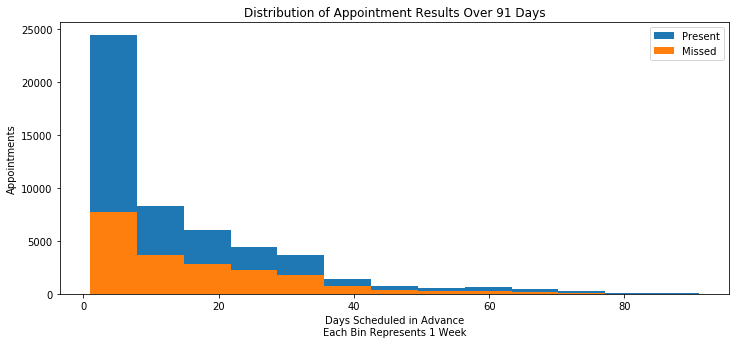

In [41]:
plt.figure(figsize=(12,5))
plt.hist(df_p['DateDifference'], bins=13, range=(start + 1,end + 1));
plt.hist(df_m['DateDifference'], bins=13, range=(start + 1,end + 1));
plt.legend(['Present','Missed']);
plt.title('Distribution of Appointment Results Over 91 Days');
plt.xlabel('Days Scheduled in Advance\nEach Bin Represents 1 Week')
plt.ylabel('Appointments');

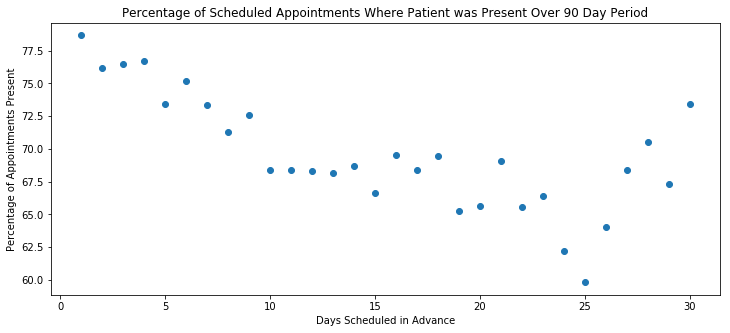

In [42]:
start = 0
end = 30
y = df.groupby('DateDifference')['ApptResult'].mean()[start:end]*100
x = range(start + 1, end + 1)
plt.figure(figsize=(12,5))
plt.scatter(x,y);
plt.title("Percentage of Scheduled Appointments Where Patient was Present Over 90 Day Period");
plt.xlabel("Days Scheduled in Advance");
plt.ylabel("Percentage of Appointments Present");

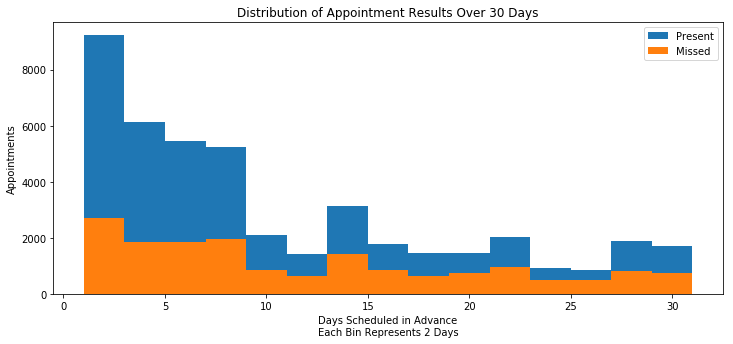

In [43]:
plt.figure(figsize=(12,5))
plt.hist(df_p['DateDifference'], bins=15, range=(start + 1,end + 1));
plt.hist(df_m['DateDifference'], bins=15, range=(start + 1,end + 1));
plt.legend(['Present','Missed']);
plt.title('Distribution of Appointment Results Over 30 Days');
plt.xlabel('Days Scheduled in Advance\nEach Bin Represents 2 Days')
plt.ylabel('Appointments');

##### Observations:
We can say that there exists a relationship between the number of days in advance an appointment is scheduled and the likeihood of them missing the appointment. Average number of appointments present starts in the high 70s in the first week, and quickly goes down to the 60s and lower.

Additional Investigation: For days 0-60, did an SMS reminder impact a patient's likelihood to show up for their appointment?

In [44]:
df1 = df.query('SMS_received == 1')
df1 = df1.groupby('DateDifference')['ApptResult'].mean()

df2 = df.query('SMS_received == 0')
df2 = df2.groupby('DateDifference')['ApptResult'].mean()

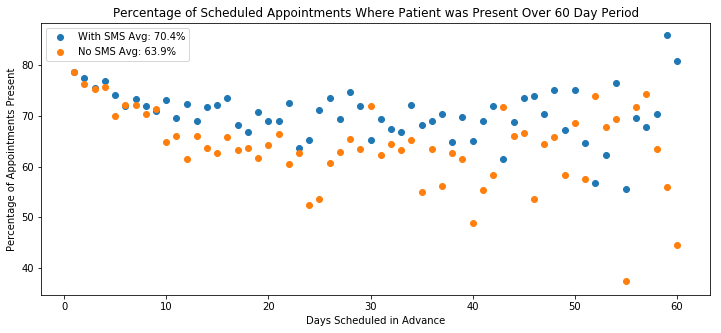

In [45]:
start = 0
end = 60

avg_result_SMS = df1[start:end].mean()
avg_result_NoSMS = df2[start:end].mean()

y1 = df1[start:end]*100
y2 = df2[start:end]*100
x = range(start + 1, end + 1)

plt.figure(figsize=(12,5))
plt.scatter(x,y1);
plt.scatter(x,y2);
plt.title("Percentage of Scheduled Appointments Where Patient was Present Over 60 Day Period");
plt.xlabel("Days Scheduled in Advance");
plt.ylabel("Percentage of Appointments Present");
plt.legend(['With SMS Avg: {}%'.format(round(avg_result_SMS*100,1)),'No SMS Avg: {}%'.format(round(avg_result_NoSMS*100,1))]);

##### Observations:
There seems to exist a relationship between of an SMS and attendance, as patients are 6.5% more likely to show up for their appointment when receiving an SMS reminder.

#### 2. What role might the location of the facility and a person's welfare status have on the likelihood of a missed appointment?

First, let's investigate the role of the facility's location on the likelihood of a patient showing up for their appointment or not.

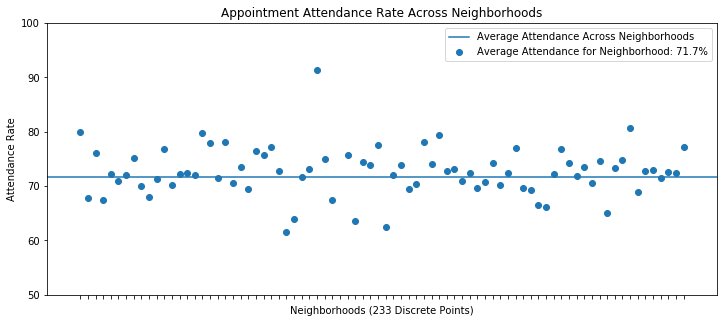

In [54]:
plt.figure(figsize=(12,5))
df1 = df.groupby('Neighbourhood')['ApptResult'].mean()*100
avg_neighborhood = df1.mean()

y = df1
x = range(1,len(y)+1)
plt.xticks(x, "");
plt.scatter(x,y);
plt.axhline(y=avg_neighborhood)
plt.ylim((50,100))
plt.title('Appointment Attendance Rate Across Neighborhoods');
plt.xlabel('Neighborhoods (233 Discrete Points)');
plt.ylabel('Attendance Rate');
plt.legend(['Average Attendance Across Neighborhoods','Average Attendance for Neighborhood: {}%'.format(round(avg_neighborhood,1))]);

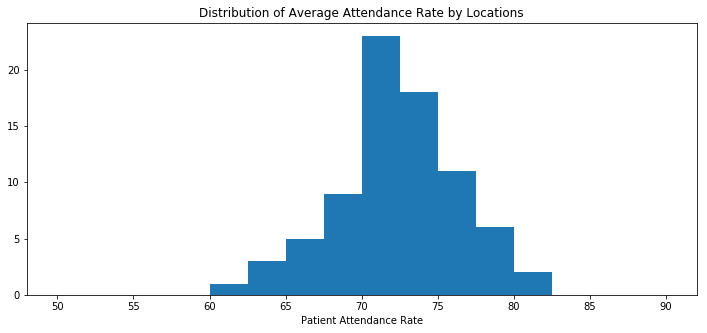

In [69]:
plt.figure(figsize=(12,5));
plt.hist(y, bins=16, range=(50,90));
plt.title('Distribution of Average Attendance Rate by Locations');
plt.xlabel('Patient Attendance Rate');

##### Observations:
Although the attendance rate for the health facility locations are normally distributed, It looks like there could exist some correlation between the facility location and the likelihood of a patient showing up for their appointment. Let's combine this analysis with a patient's Welfare status.

In [47]:
welfare_mean = df['WelfareScholarship'].describe()[1]
welfare_mean_present = df_p['WelfareScholarship'].describe()[1]
welfare_mean_missed = df_m['WelfareScholarship'].describe()[1]

mean_result_welfare = df['ApptResult'].mean()
mean_result_if_welfare = df.groupby('WelfareScholarship')['ApptResult'].mean()[0]
mean_result_not_welfare = df.groupby('WelfareScholarship')['ApptResult'].mean()[1]

##### Observations:
<li>9.2% of patients are on welfare status.</li>
<li>The Mean Welfare status for present appointments is 8.4%, or .8% lower than the overall average</li>
<li>The Mean Welfare status for missed appointments is 11.4%, or 2.2% higher that the overall average</li>
<li>If the patient is on Welfare, there is a 65.0% likelihood they will show up for their appointment, or 6.5% more likely to miss their appointment</li>
<li>If the patient is not on Welfare, there is a 72.1% likelihood they will show up for their appointment, or .6% more likely to show up for their appointment</li>

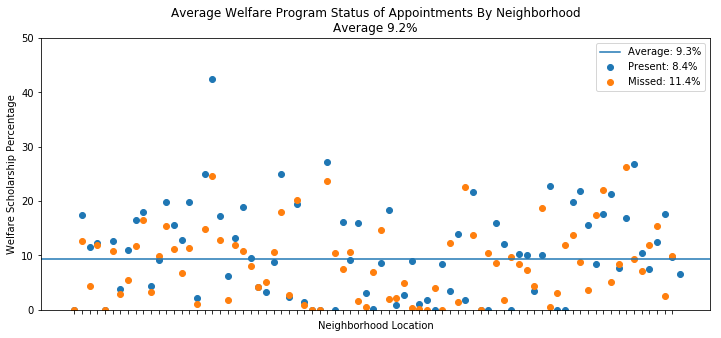

In [48]:
plt.figure(figsize=(12,5))

y = df_m.groupby('Neighbourhood')['WelfareScholarship'].mean()*100
x = range(1,len(y)+1)
plt.scatter(x,y);

y = df_p.groupby('Neighbourhood')['WelfareScholarship'].mean()*100
x = range(1,len(y)+1)
plt.scatter(x,y);

plt.axhline(y=welfare_mean*100)
plt.ylim(0,50)
plt.xticks(x, '');
plt.title('Average Welfare Program Status of Appointments By Neighborhood\nAverage 9.2%');
plt.ylabel('Welfare Scholarship Percentage');
plt.xlabel('Neighborhood Location')
plt.legend(['Average: {}%'.format(round(welfare_mean*100,1)),'Present: {}%'.format(round(welfare_mean_present*100,1)),'Missed: {}%'.format(round(welfare_mean_missed*100,1))]);

In [49]:
df_neighborhoods = df.groupby('Neighbourhood').mean()

When Neighborhoods are above the mean Attendance rate and below the mean Welfare Scholarship rate, what is the mean Welfare Scholarship rate? How does this compare to the mean Welfare Scholarship rate when only the Attendance Rate is above the mean and when only when the Welfare Sholarship rate is less than the mean?

In [50]:
means_Aw = df_neighborhoods.query('ApptResult > {} and WelfareScholarship < {}'.format(mean,welfare_mean))['WelfareScholarship']
means_AW = df_neighborhoods.query('ApptResult > {} and WelfareScholarship > {}'.format(mean,welfare_mean))['WelfareScholarship']
means_aW = df_neighborhoods.query('ApptResult < {} and WelfareScholarship > {}'.format(mean,welfare_mean))['WelfareScholarship']
means_aw = df_neighborhoods.query('ApptResult < {} and WelfareScholarship < {}'.format(mean,welfare_mean))['WelfareScholarship']
means_A = df_neighborhoods.query('ApptResult > {}'.format(mean)).mean()['WelfareScholarship']
means_a = df_neighborhoods.query('ApptResult < {}'.format(mean)).mean()['WelfareScholarship']
means_w = df_neighborhoods.query('WelfareScholarship < {}'.format(welfare_mean)).mean()['WelfareScholarship']
means_W = df_neighborhoods.query('WelfareScholarship > {}'.format(welfare_mean)).mean()['WelfareScholarship']

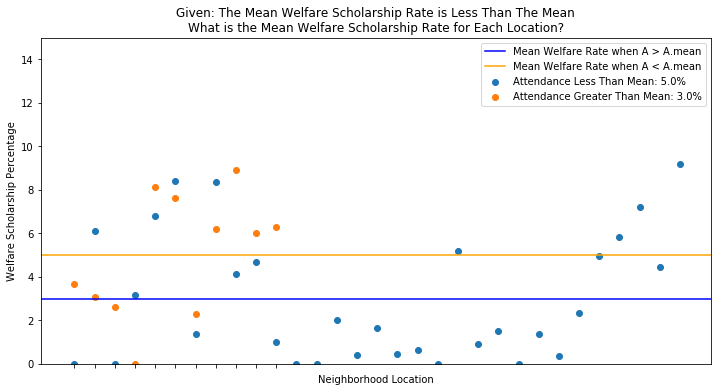

In [51]:
plt.figure(figsize=(12,6))

plt.axhline(y=means_Aw.mean()*100, color='blue')
plt.axhline(y=means_aw.mean()*100, color='orange')

y = means_Aw*100
x = range(1,len(y)+1)
plt.scatter(x,y);

y = means_aw*100
x = range(1,len(y)+1)
plt.scatter(x,y);

plt.ylim(0,15)
plt.xticks(x, '');
plt.title('Given: The Mean Welfare Scholarship Rate is Less Than The Mean\nWhat is the Mean Welfare Scholarship Rate for Each Location?');
plt.ylabel('Welfare Scholarship Percentage');
plt.xlabel('Neighborhood Location')
plt.legend(['Mean Welfare Rate when A > A.mean','Mean Welfare Rate when A < A.mean','Attendance Less Than Mean: {}%'.format(round(means_aw.mean()*100,1)),'Attendance Greater Than Mean: {}%'.format(round(means_Aw.mean()*100,1))]);

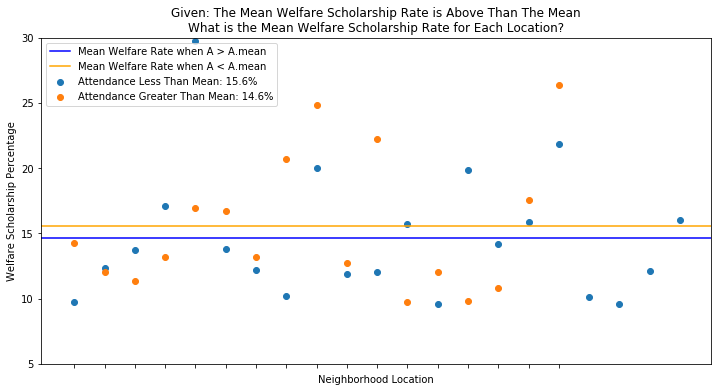

In [52]:
plt.figure(figsize=(12,6))

plt.axhline(y=means_AW.mean()*100, color='blue')
plt.axhline(y=means_aW.mean()*100, color='orange')

y = means_AW*100
x = range(1,len(y)+1)
plt.scatter(x,y);

y = means_aW*100
x = range(1,len(y)+1)
plt.scatter(x,y);

plt.ylim(5,30)
plt.xticks(x, '');
plt.title('Given: The Mean Welfare Scholarship Rate is Above Than The Mean\nWhat is the Mean Welfare Scholarship Rate for Each Location?');
plt.ylabel('Welfare Scholarship Percentage');
plt.xlabel('Neighborhood Location')
plt.legend(['Mean Welfare Rate when A > A.mean','Mean Welfare Rate when A < A.mean','Attendance Less Than Mean: {}%'.format(round(means_aW.mean()*100,1)),'Attendance Greater Than Mean: {}%'.format(round(means_AW.mean()*100,1))]);

##### Observations:
<li>It looks like there exists a consistent, al beit marginal, correlation between Welfare Scholarship rate and likelihood to show up for an appointment.</li>
<li>For neighborhoods whose patients' welfare rate is below the overall average, the mean attendance rate is 2.0% higher among patients whose welfare rate was below the mean.</li>
<li>For neighborhoods whose patients' welfare rate is above the overall average, the mean attendance rate is 1.2% higher among patients whose welfare rate was below the mean.</li>

#### 3. Does a person's health conditions affect the likelihood of mission an appointment?

In [98]:
p_means = df_p.mean()
m_means = df_m.mean()

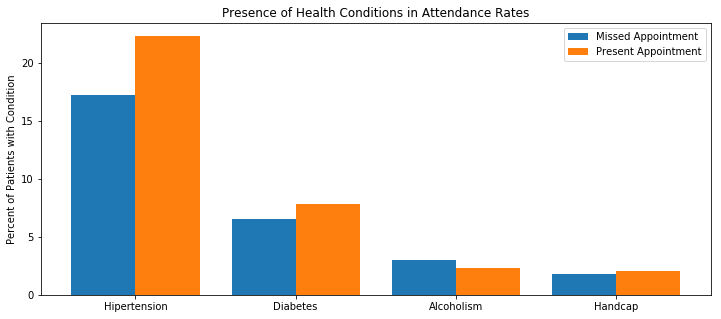

In [380]:
import numpy as np
plt.figure(figsize=(12,5))
plt.title('Presence of Health Conditions in Attendance Rates')

w = .4
labels = m_means.index[5:-3].tolist()
location = np.arange(1,len(xvalues)+1) + w/2

y_m = m_means[5:-3]*100;
y_p = p_means[5:-3]*100;
plt.bar(location-w/2,y_m, width=w, label='Missed Appointment');
plt.bar(location+w/2,y_p, width=w, label='Present Appointment');

plt.xticks(location, labels);
plt.ylabel('Percent of Patients with Condition');
plt.legend();

In [205]:
p_means[5:-3] - m_means[5:-3]

Hipertension    0.051194
Diabetes        0.013052
Alcoholism     -0.006911
Handcap         0.002451
dtype: float64

##### Observation:
Hipertension looks to be a more common health condition than there other conditions. All health conditions except Alocholism positively impact the attendance rate, while an alcoholic patient is more likely to miss an appointment.

In [383]:
hipertension_rate = df.query('Hipertension == 1')['ApptResult'].mean()*100
diabetes_rate = df.query('Diabetes == 1')['ApptResult'].mean()*100
alcoholism_rate = df.query('Alcoholism == 1')['ApptResult'].mean()*100
hipertension_rate = df.query('Handcap == 1')['ApptResult'].mean()*100

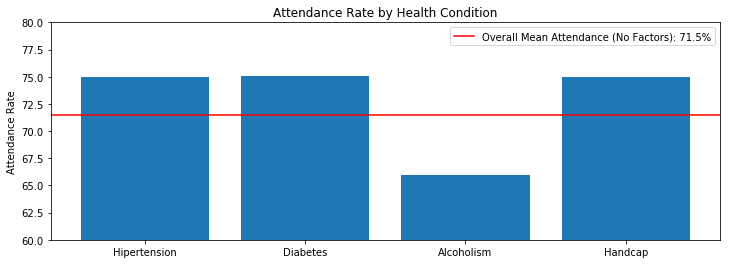

In [384]:
labels = m_means.index[5:-3].tolist()
x = range(1, len(labels)+1)
y = [hipertension_rate, diabetes_rate, alcoholism_rate, hipertension_rate]
mean_y = sum(y) / len(y)

plt.figure(figsize=(12,4))
plt.axhline(mean*100, label='Overall Mean Attendance (No Factors): {}%'.format(round(mean*100,1)), color='r');
plt.bar(x,y);
plt.xticks(x,labels);
plt.ylim(60,80);
plt.title('Attendance Rate by Health Condition')
plt.ylabel('Attendance Rate');
plt.legend();

Let's isolate and anlayze the three health conditions that positively impact the attendance rate - Hipertension, Diabetes, Handcap. And then let's consider Alocholism and separate this field to think of it as an inverse factor.

In [389]:
no_condition_rate = df.query('Handcap == 0 and Hipertension == 0 and Diabetes == 0')['ApptResult'].mean()*100
any_condition_rate = df.query('Handcap == 1 or Hipertension == 1 or Diabetes == 1')['ApptResult'].mean()*100
all_condition_rate = df.query('Handcap == 1 and Hipertension == 1 and Diabetes == 1')['ApptResult'].mean()*100

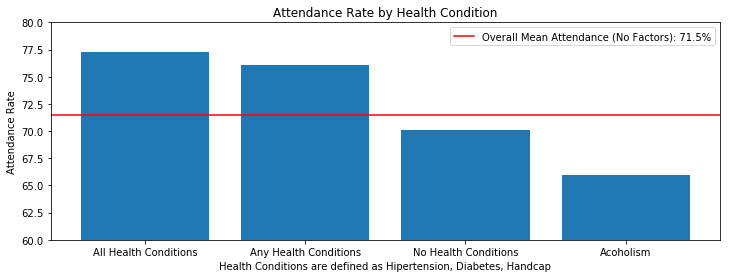

In [390]:
labels = ['All Health Conditions','Any Health Conditions','No Health Conditions','Acoholism']
x = range(1, len(labels)+1)
y = [all_condition_rate, any_condition_rate, no_condition_rate, alcoholism_rate]

plt.figure(figsize=(12,4))
plt.bar(x,y);
plt.axhline(mean*100, label='Overall Mean Attendance (No Factors): {}%'.format(round(mean*100,1)), color='r');
plt.xticks(x,labels);
plt.ylim(60,80);
plt.title('Attendance Rate by Health Condition')
plt.ylabel('Attendance Rate');
plt.xlabel('Health Conditions are defined as Hipertension, Diabetes, Handcap')
plt.legend();

##### Observation:
A patient is more likely to show up to their appointment if they have a health condition (hipertension, diabetes, handcap):
<li>77.3% attendance rate if patient has all hipertension, diabetes, and handcap, or 5.8% higher than the average</li>
<li>76.1% attendance rate if patient has at least one of hipertension, diabetes, or handcap, or 4.6% higher than the average</li>
<li>70.1% attendance rate if patient has no condition, or 1.4% lower than the average</li>
<li>65.9% attendance rate if patient has alcoholism, or 5.6% lower than the average</li>

### <a id='conclusions'></a>
## Conclusions

Based on the data we have seen, we can draw some conclusions and correlations with our findings. These relate to the amount of days between then a patient schedules an appointment and their appointment date, whether or not they received an SMS message, a health facilities location and a patient's welfare status, and finally the health condition of the patient.<br><br>
For data that was aggregated by time, we limited our analysis to time frames under 100 days as there are so few records after 100 days that it would skew the statistics. For example, a histogram quickly reveals to us that the bulk of appointments were scheduled within 10 days of the appointment.

#### 1. Patients are more likely to miss their appointment as the gap increases between when they scheduled their appointment and their appointment date.

We find a clear inverse relationship between the number of days between an appointment's scheduled date and the actual appointment against the attendance right. If the patient scheduled an appointment within 1-5 days of the appointment, they are 75-80% likely to show-up, with the likelihood quickly descending after 1-2 weeks, eventually falling to below 60-65%. We do not know enough to explain any reasoning, although there may be three rational inferences for this relationship:<br>
1. The patient is more likely to remember
2. The patient has less schedule conflicts
3. The patient has a more urgent health condition

#### 2. Patients are more likely to show up for their appointment when they receive an SMS message.

Although overall we see that there is a nominal impact when a patient receives an SMS (+1.9%), by narrowing our focus to the first 60 days, we see that patients were 6.5% more likely to attend when they received and SMS message than if they did not receive an SMS. When we assume that a patient does not need an SMS reminder if they scheduled their appointment within the first 3 days, our relationship strengths to a 7% increase.

#### 3. The location of the health facility has little impact on the likelihood of a patient's attendance.

There is slight variance of attendance rates across the neighborhood location; it is normally distributed so we can assume that there is little to no correlation between location and at the likelihood of a patient to attend or not. We could, however, further investigate if any locations have poor infrastructure or mass transit access.

#### 4. Patients on welfare scholarship are more likely to miss their appointment.

On average, a patient on welfare is 65% likely to show up for their appointment, against an average of 72.1% likelihood of showing up if they are not on welfare. Although only 9.2% of the patients were on welfare, 11.4% of the missed appointments are represented by patients on welfare.<br><br>
Further investigation considers welfare by neighborhood. When a neighborhoods mean attendance rate was greater than the overall attendance rate, we found that neighborhood's mean welfare rate was lower than the overall mean welfare rate. This same relationship exists in the inverse.

#### 5. A patient's health condition(s) have an impact on their likelihood of showing up for their appointment.

There is a clear relationship that if a patient has a health condition (hipertension, diabetes, or handcap), they are more likely to show up for their appointment. If a patient has all 3 conditions, there are 5.8% more likely to show up, if they have at least one of the conditions they are 4.6% more likely to show up. If they have none of the conditions, they are just as likely to show up as the overall average (71.5%). If the patient has alcoholism, they are less likely to show up to their appointment by 5.6%.

#### Overall Conclusions

We observe that the most likely patients to show up for their appointment are patients that have the following characteristics:
1. Scheduled their appointment within one week of their appointment
2. Received an SMS message
3. Have at least one of the described health conditions

#### Limitations of Data Set

Although we were able to provide a detailed analysis of the data set, we would like to have had access to additional data to help answer our questions and analysis more thoroughly. Here are some additional factors that we did not have access to and therefore limited our analysis:
1. *How was the appoinment made?*<br>
Was the appointment made in-person, over the phone (if so, who initiated?), or online?
2. *How accessible is the facility*?<br>
Is it within 1 mile of a freeway? Is there mass transit available? Is it centrally located within a population?
3. *What was the nature of the appointment?*<br>
Was it a routine health check-up? Was the patient suffering from a chronic disease? Was the patient scheduling an appointment to address an urgent health condition? Was it a follow-up appointment?
4. *What was there inclement weather on the appointment day?*<br>
Just as a rainy day negatively impacts voter turnout, perhaps rain or snow would make a patient more likely to miss their appointment